In [1]:
#Importing all the Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Concatenate
from keras.models import Model
from keras.layers import Bidirectional
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import pickle


from sklearn.preprocessing import FunctionTransformer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.pipeline import Pipeline
import re
import pandas as pd
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import spacy

### Dataset
Amazon Customer Reviews (also known as Product Reviews) contain all of the reviews of well-known products on Amazon. Over 100 million reviews have been written by consumers of Amazon since the first one appeared in 1995, expressing their thoughts and sharing their experiences with various products on the Amazon.com website. All these were released to the public and available on Kaggle. The datset used in this work is US video games data.


The dataset is available at
(https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset?select=amazon_reviews_us_Digital_Video_Games_v1_00.tsv)

In [2]:
#Loading the data to df
df=pd.read_csv('C:\\Users\\Dell\\Downloads\\Telegram Desktop\\amazon_reviews_us_Digital_Video_Games_v1_00.tsv', sep='\t')
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,21269168,RSH1OZ87OYK92,B013PURRZW,603406193,Madden NFL 16 - Xbox One Digital Code,Digital_Video_Games,2,2,3,N,N,A slight improvement from last year.,I keep buying madden every year hoping they ge...,2015-08-31
1,US,133437,R1WFOQ3N9BO65I,B00F4CEHNK,341969535,Xbox Live Gift Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome,2015-08-31
2,US,45765011,R3YOOS71KM5M9,B00DNHLFQA,951665344,Command & Conquer The Ultimate Collection [Ins...,Digital_Video_Games,5,0,0,N,Y,Hail to the great Yuri!,If you are prepping for the end of the world t...,2015-08-31
3,US,113118,R3R14UATT3OUFU,B004RMK5QG,395682204,Playstation Plus Subscription,Digital_Video_Games,5,0,0,N,Y,Five Stars,Perfect,2015-08-31
4,US,22151364,RV2W9SGDNQA2C,B00G9BNLQE,640460561,Saints Row IV - Enter The Dominatrix [Online G...,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31


### Data Preprocessing

#### Converting the review text to lower case

In [3]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
df.dropna(axis=0)
df['review_text'] = df['review_body'].str.lower()   #Converting to Lower case
df['review_text'].head()

0    i keep buying madden every year hoping they ge...
1                                              awesome
2    if you are prepping for the end of the world t...
3                                              perfect
4                                             awesome!
Name: review_text, dtype: object

#### Removing all the punctuation marks if present

In [4]:
df['review_text'] = df['review_text'].str.replace('[^\w\s]','') #Removing punctuations
df['review_text'].head()

C:\Users\Dell\AppData\Local\Temp/ipykernel_8688/307170365.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_text'] = df['review_text'].str.replace('[^\w\s]','') #Removing punctuations


0    i keep buying madden every year hoping they ge...
1                                              awesome
2    if you are prepping for the end of the world t...
3                                              perfect
4                                              awesome
Name: review_text, dtype: object

#### Removing numbers in the data if present

In [5]:
df['review_text'] = df['review_text'].str.replace('\d+', '') #Removing numbers
df.dropna()
df['review_text'].head()

C:\Users\Dell\AppData\Local\Temp/ipykernel_8688/1880823837.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_text'] = df['review_text'].str.replace('\d+', '') #Removing numbers


0    i keep buying madden every year hoping they ge...
1                                              awesome
2    if you are prepping for the end of the world t...
3                                              perfect
4                                              awesome
Name: review_text, dtype: object

#### Removing Stop Words in the data 

In [6]:
#Removing the stop words 
df = df[df['review_text'].notnull()]
stop = stopwords.words('english')
df['review_text'] = df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [7]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_text
0,US,21269168,RSH1OZ87OYK92,B013PURRZW,603406193,Madden NFL 16 - Xbox One Digital Code,Digital_Video_Games,2,2,3,N,N,A slight improvement from last year.,I keep buying madden every year hoping they ge...,2015-08-31,keep buying madden every year hoping get back ...
1,US,133437,R1WFOQ3N9BO65I,B00F4CEHNK,341969535,Xbox Live Gift Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome,2015-08-31,awesome
2,US,45765011,R3YOOS71KM5M9,B00DNHLFQA,951665344,Command & Conquer The Ultimate Collection [Ins...,Digital_Video_Games,5,0,0,N,Y,Hail to the great Yuri!,If you are prepping for the end of the world t...,2015-08-31,prepping end world one things installed youren...
3,US,113118,R3R14UATT3OUFU,B004RMK5QG,395682204,Playstation Plus Subscription,Digital_Video_Games,5,0,0,N,Y,Five Stars,Perfect,2015-08-31,perfect
4,US,22151364,RV2W9SGDNQA2C,B00G9BNLQE,640460561,Saints Row IV - Enter The Dominatrix [Online G...,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31,awesome


#### Creating a target variable using the ratings given by customers

In [8]:
#Creating a Target Variable with condition if the rating is less than 3, it will be a bad product otherwise not.
df['bad_product'] = 0
df.loc[df['star_rating'] <= 2, 'bad_product'] = 1
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_text,bad_product
0,US,21269168,RSH1OZ87OYK92,B013PURRZW,603406193,Madden NFL 16 - Xbox One Digital Code,Digital_Video_Games,2,2,3,N,N,A slight improvement from last year.,I keep buying madden every year hoping they ge...,2015-08-31,keep buying madden every year hoping get back ...,1
1,US,133437,R1WFOQ3N9BO65I,B00F4CEHNK,341969535,Xbox Live Gift Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome,2015-08-31,awesome,0
2,US,45765011,R3YOOS71KM5M9,B00DNHLFQA,951665344,Command & Conquer The Ultimate Collection [Ins...,Digital_Video_Games,5,0,0,N,Y,Hail to the great Yuri!,If you are prepping for the end of the world t...,2015-08-31,prepping end world one things installed youren...,0
3,US,113118,R3R14UATT3OUFU,B004RMK5QG,395682204,Playstation Plus Subscription,Digital_Video_Games,5,0,0,N,Y,Five Stars,Perfect,2015-08-31,perfect,0
4,US,22151364,RV2W9SGDNQA2C,B00G9BNLQE,640460561,Saints Row IV - Enter The Dominatrix [Online G...,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31,awesome,0


#### Performing the Lemmetization

In [9]:
#Lemmatization
def Lemm(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
df['review_text']= df['review_text'].apply(Lemm)
df.head(20)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_text,bad_product
0,US,21269168,RSH1OZ87OYK92,B013PURRZW,603406193,Madden NFL 16 - Xbox One Digital Code,Digital_Video_Games,2,2,3,N,N,A slight improvement from last year.,I keep buying madden every year hoping they ge...,2015-08-31,keep buy madden every year hope get back footb...,1
1,US,133437,R1WFOQ3N9BO65I,B00F4CEHNK,341969535,Xbox Live Gift Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome,2015-08-31,awesome,0
2,US,45765011,R3YOOS71KM5M9,B00DNHLFQA,951665344,Command & Conquer The Ultimate Collection [Ins...,Digital_Video_Games,5,0,0,N,Y,Hail to the great Yuri!,If you are prepping for the end of the world t...,2015-08-31,preppe end world one thing instal yourendofthe...,0
3,US,113118,R3R14UATT3OUFU,B004RMK5QG,395682204,Playstation Plus Subscription,Digital_Video_Games,5,0,0,N,Y,Five Stars,Perfect,2015-08-31,perfect,0
4,US,22151364,RV2W9SGDNQA2C,B00G9BNLQE,640460561,Saints Row IV - Enter The Dominatrix [Online G...,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31,awesome,0
5,US,22151364,R3CFKLIZ0I2KOB,B00IMIL498,621922192,Double Dragon: Neon [Online Game Code],Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31,awesome,0
6,US,38426028,R1LRYU1V0T3O38,B00S00IJH8,215163395,Sims 4,Digital_Video_Games,4,0,0,N,Y,i like the new skills like herbalism in this,"i like the new skills like herbalism in this, ...",2015-08-31,like new skill like herbalism camping fun also...,0
7,US,6057518,R44QKV6FE5CJ2,B004RMK4BC,384246568,Playstation Network Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Super,2015-08-31,super,0
8,US,20715661,R2TX1KLPXXXNYS,B00K59HKIQ,384246568,Playstation Network Card,Digital_Video_Games,5,0,0,N,Y,Easy & Fast,"Excellent, fast and secure!!!",2015-08-31,excellent fast secure,0
9,US,26540306,R1JEEW4C6R89BA,B00K59HKIQ,384246568,Playstation Network Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Ok,2015-08-31,ok,0


In [10]:
df_final = df[["review_text","bad_product"]]

In [11]:
df_final

,review_text,bad_product
0,keep buy madden every year hope get back footb...,1
1,awesome,0
2,preppe end world one thing instal yourendofthe...,0
3,perfect,0
4,awesome,0
...,...,...
144719,worry due review see do not time wait package ...,0
144720,download christmas present kid I ve spend well...,1
144721,previous reviewer correct noting install take ...,0
144722,download son birthday yesterday intend install...,1


#### Splitting the data

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(df_final['review_text'],df_final['bad_product'], test_size = 0.20, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(115777,) (115777,)
(28945,) (28945,)


#### Converting the train text into encoded labels

In [14]:
review = X_train.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [15]:
with open('tokenizer.pickle', 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
print(review[0])
print(encoded_docs[0])

expect plus cumlate score one game next
[159, 272, 641, 9, 1, 201]


In [17]:
print(padded_sequence[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 159 272 641   9
   1 201]


In [18]:
X_re = padded_sequence
Y_re = Y_train.values
#Y_re=df_final.bad_product.factorize()

In [21]:
product_label = Y_train.factorize()
product_label

(array([0, 0, 1, ..., 1, 1, 1], dtype=int64),
 Int64Index([1, 0], dtype='int64'))

## LSTM 

In [22]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_length,input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50,dropout=0.5,recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           2647040   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,663,691
Trainable params: 2,663,691
Non-trainable params: 0
______________________________________________

In [23]:
checkpoint = ModelCheckpoint("my_h5515_model_text.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]

In [26]:
history= model.fit(X_re,Y_re,validation_split=0.2,epochs=5,batch_size=32,callbacks=callbacks)

Epoch 1/5
2895/2895 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8755
Epoch 1: saving model to my_h5515_model_text.h5
2895/2895 [==============================] - 474s 163ms/step - loss: 0.3019 - accuracy: 0.8755 - val_loss: 0.2564 - val_accuracy: 0.8978
Epoch 2/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2481 - accuracy: 0.8992
Epoch 2: saving model to my_h5515_model_text.h5
2895/2895 [==============================] - 474s 164ms/step - loss: 0.2481 - accuracy: 0.8992 - val_loss: 0.2474 - val_accuracy: 0.8987
Epoch 3/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9057
Epoch 3: saving model to my_h5515_model_text.h5
2895/2895 [==============================] - 470s 162ms/step - loss: 0.2342 - accuracy: 0.9057 - val_loss: 0.2482 - val_accuracy: 0.8996
Epoch 4/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9084
Epoch 4: saving model to my_h5515_model_text.h5
2895/2895

In [27]:
#Saving the Model
model_json = model.to_json()
with open("model_h5515_text.json","w") as json_file:
    json_file.write(model_json)


In [30]:
#TO open the model without training

# to open 
from keras.models import model_from_json
json_file = open('model_h5515_text.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("my_h5515_model_text.h5")


#### Processing the test data

In [31]:
test_reviews = X_test.values
encoded_docs = tokenizer.texts_to_sequences(test_reviews)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)
test_data = padded_sequence

In [32]:
predict_x=loaded_model.predict(test_data) 


#Y_test
classes_x=np.rint(predict_x)

Y_pred = classes_x.flatten()


905/905 [==============================] - 19s 21ms/step


In [33]:
print("Accuracy-:",accuracy_score(Y_test.values,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test.values, Y_pred))
print("Classification Report:\n",classification_report(Y_test.values,Y_pred))

Accuracy-: 0.9022974607013301
Confusion Matrix:
 [[21235  1102]
 [ 1726  4882]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94     22337
           1       0.82      0.74      0.78      6608

    accuracy                           0.90     28945
   macro avg       0.87      0.84      0.86     28945
weighted avg       0.90      0.90      0.90     28945



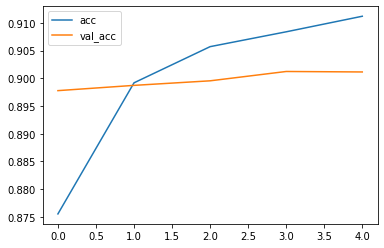

<Figure size 432x288 with 0 Axes>

In [34]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

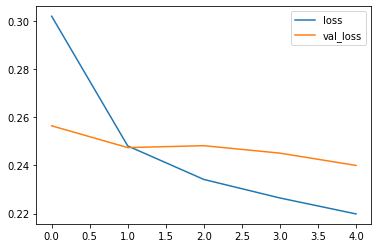

<Figure size 432x288 with 0 Axes>

In [35]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

### Trying to balance the data to improve accuracy 

In [37]:

from imblearn.over_sampling import SMOTE
x,y = SMOTE().fit_resample(X_re,Y_train)

In [38]:
np.array(np.unique(y, return_counts=True)).T

array([[    0, 89811],
       [    1, 89811]], dtype=int64)

In [39]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_length,input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50,dropout=0.5,recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 32)           2647040   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,663,691
Trainable params: 2,663,691
Non-trainable params: 0
____________________________________________

In [40]:
checkpoint = ModelCheckpoint("my_h5_imb_model_text1.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]

In [41]:
history= model.fit(x,y,validation_split=0.2,epochs=5,batch_size=32,callbacks=callbacks)

Epoch 1/5
4491/4491 [==============================] - ETA: 0s - loss: 0.4324 - accuracy: 0.7984
Epoch 1: saving model to my_h5_imb_model_text1.h5
4491/4491 [==============================] - 737s 163ms/step - loss: 0.4324 - accuracy: 0.7984 - val_loss: 0.6255 - val_accuracy: 0.7283
Epoch 2/5
4491/4491 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.8619
Epoch 2: saving model to my_h5_imb_model_text1.h5
4491/4491 [==============================] - 746s 166ms/step - loss: 0.3262 - accuracy: 0.8619 - val_loss: 0.3988 - val_accuracy: 0.8189
Epoch 3/5
4491/4491 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.8822
Epoch 3: saving model to my_h5_imb_model_text1.h5
4491/4491 [==============================] - 729s 162ms/step - loss: 0.2832 - accuracy: 0.8822 - val_loss: 0.2464 - val_accuracy: 0.8844
Epoch 4/5
4491/4491 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.8899
Epoch 4: saving model to my_h5_imb_model_text1.h5
4

In [43]:
#Saving the Model
model_json = model.to_json()
with open("model_h5_imb_text1.json","w") as json_file:
    json_file.write(model_json)

In [44]:
#TO open the model without training

# to open 
from keras.models import model_from_json
json_file = open('model_h5_imb_text1.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("my_h5_imb_model_text1.h5")


In [45]:
predict_x=loaded_model.predict(test_data) 


#Y_test
classes_x=np.rint(predict_x)

Y_pred = classes_x.flatten()


905/905 [==============================] - 18s 20ms/step


In [46]:
print("Accuracy-:",accuracy_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n",classification_report(Y_test,Y_pred))

Accuracy-: 0.8949041285196061
Confusion Matrix:
 [[20918  1419]
 [ 1623  4985]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93     22337
           1       0.78      0.75      0.77      6608

    accuracy                           0.89     28945
   macro avg       0.85      0.85      0.85     28945
weighted avg       0.89      0.89      0.89     28945



#### The accuracy did not get improved much, so we are sticking to the original data

#### If you are more interested, Below are some more Deep Learning and Machine Learning Techniques. You can check them out.

## CNN Model

In [53]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=200))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          9453100   
                                                                 
 conv1d (Conv1D)             (None, 193, 32)           25632     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 96, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                30730     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                      

In [54]:
# compile network
checkpoint = ModelCheckpoint("my_h6_model_text1.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history1 = model.fit(X_re,Y_re,validation_split=0.2,epochs=5,batch_size=32,callbacks=callbacks)

Epoch 1/5
2895/2895 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8766
Epoch 1: saving model to my_h6_model_text.h5
2895/2895 [==============================] - 337s 116ms/step - loss: 0.3145 - accuracy: 0.8766 - val_loss: 0.2777 - val_accuracy: 0.8896
Epoch 2/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9081
Epoch 2: saving model to my_h6_model_text.h5
2895/2895 [==============================] - 336s 116ms/step - loss: 0.2331 - accuracy: 0.9081 - val_loss: 0.2776 - val_accuracy: 0.8922
Epoch 3/5
2895/2895 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9313
Epoch 3: saving model to my_h6_model_text.h5
2895/2895 [==============================] - 338s 117ms/step - loss: 0.1803 - accuracy: 0.9313 - val_loss: 0.2882 - val_accuracy: 0.8883
Epoch 4/5
2895/2895 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9562
Epoch 4: saving model to my_h6_model_text.h5
2895/2895 [==========

In [55]:
#Saving the Model
model_json = model.to_json()
with open("model_h6_text1.json","w") as json_file:
    json_file.write(model_json)


In [56]:
#TO open the model without training

# to open 
from keras.models import model_from_json
json_file = open('model_h6_text1.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("my_h6_model_text1.h5")


In [57]:
predict_x=loaded_model.predict(test_data) 


#Y_test
classes_x=np.rint(predict_x)

Y_pred = classes_x.flatten()


905/905 [==============================] - 3s 4ms/step


In [58]:
print("Accuracy-:",accuracy_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n",classification_report(Y_test,Y_pred))

Accuracy-: 0.8761444118155122
Confusion Matrix:
 [[20471  1866]
 [ 1719  4889]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     22337
           1       0.72      0.74      0.73      6608

    accuracy                           0.88     28945
   macro avg       0.82      0.83      0.83     28945
weighted avg       0.88      0.88      0.88     28945



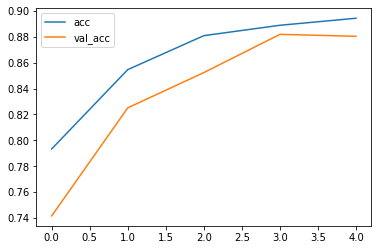

<Figure size 432x288 with 0 Axes>

In [59]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

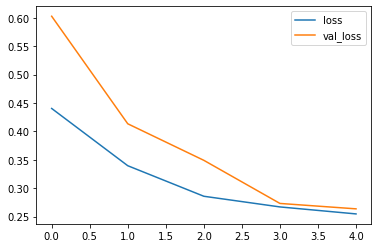

<Figure size 432x288 with 0 Axes>

In [60]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

## CNN + LSTM

In [61]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=200))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 100)          9453100   
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 32)           9632      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 100)               53200     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 9,516,033
Trainable params: 9,516,033
Non-trainable params: 0
____________________________________________

In [62]:
# compile network
checkpoint = ModelCheckpoint("my_h7_model_text1.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history2 = model.fit(X_re,Y_re,validation_split=0.2,epochs=5,batch_size=32,callbacks=callbacks)

Epoch 1/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.8896
Epoch 1: saving model to my_h7_model_text.h5
2895/2895 [==============================] - 453s 156ms/step - loss: 0.2682 - accuracy: 0.8896 - val_loss: 0.2537 - val_accuracy: 0.8989
Epoch 2/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9132
Epoch 2: saving model to my_h7_model_text.h5
2895/2895 [==============================] - 407s 141ms/step - loss: 0.2147 - accuracy: 0.9132 - val_loss: 0.2469 - val_accuracy: 0.8963
Epoch 3/5
2895/2895 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9256
Epoch 3: saving model to my_h7_model_text.h5
2895/2895 [==============================] - 410s 142ms/step - loss: 0.1882 - accuracy: 0.9256 - val_loss: 0.2484 - val_accuracy: 0.9009
Epoch 4/5
2895/2895 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9374
Epoch 4: saving model to my_h7_model_text.h5
2895/2895 [==========

In [63]:
#Saving the Model
model_json = model.to_json()
with open("model_h7_text1.json","w") as json_file:
    json_file.write(model_json)


In [64]:
#TO open the model without training

# to open 
from keras.models import model_from_json
json_file = open('model_h7_text1.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("my_h7_model_text1.h5")


In [65]:
predict_x=loaded_model.predict(test_data) 


#Y_test
classes_x=np.rint(predict_x)

Y_pred = classes_x.flatten()


905/905 [==============================] - 17s 18ms/step


In [66]:
print("Accuracy-:",accuracy_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n",classification_report(Y_test,Y_pred))

Accuracy-: 0.8960442217999655
Confusion Matrix:
 [[20938  1399]
 [ 1610  4998]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93     22337
           1       0.78      0.76      0.77      6608

    accuracy                           0.90     28945
   macro avg       0.85      0.85      0.85     28945
weighted avg       0.89      0.90      0.90     28945



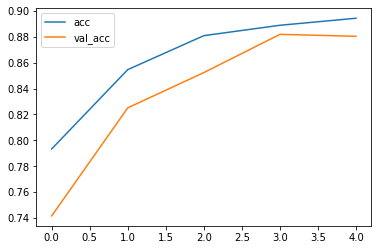

<Figure size 432x288 with 0 Axes>

In [67]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

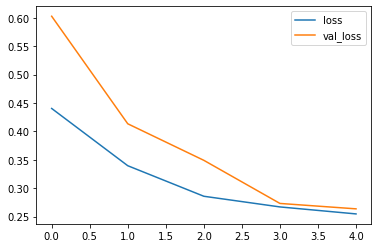

<Figure size 432x288 with 0 Axes>

In [68]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

### Bi-LSTM 

In [100]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_length,input_length=200))
model.add(Bidirectional(LSTM(64,dropout=0.5,recurrent_dropout=0.5)))
model.add(Dense(24,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 32)           3024992   
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 24)                3096      
                                                                 
 dense_14 (Dense)            (None, 1)                 25        
                                                                 
Total params: 3,077,777
Trainable params: 3,077,777
Non-trainable params: 0
_________________________________________________________________
None


In [85]:
# compile network
checkpoint = ModelCheckpoint("my_h8_model_text1.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]
# fit network
history3 = model.fit(X_re,Y_re,validation_split=0.2,epochs=5,batch_size=32,callbacks=callbacks)

Epoch 1/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.8819
Epoch 1: saving model to my_h8_model_text.h5
2895/2895 [==============================] - 586s 201ms/step - loss: 0.2872 - accuracy: 0.8819 - val_loss: 0.2743 - val_accuracy: 0.8904
Epoch 2/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.9030
Epoch 2: saving model to my_h8_model_text.h5
2895/2895 [==============================] - 603s 208ms/step - loss: 0.2380 - accuracy: 0.9030 - val_loss: 0.2457 - val_accuracy: 0.8997
Epoch 3/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9097
Epoch 3: saving model to my_h8_model_text.h5
2895/2895 [==============================] - 602s 208ms/step - loss: 0.2238 - accuracy: 0.9097 - val_loss: 0.2476 - val_accuracy: 0.8991
Epoch 4/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.9135
Epoch 4: saving model to my_h8_model_text.h5
2895/2895 [==========

In [101]:
#Saving the Model
model_json = model.to_json()
with open("model_h8_text1.json","w") as json_file:
    json_file.write(model_json)


In [88]:
#TO open the model without training

# to open 
from keras.models import model_from_json
json_file = open('model_h8_text1.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("my_h8_model_text1.h5")


In [89]:
predict_x=loaded_model.predict(test_data) 


#Y_test
classes_x=np.rint(predict_x)

Y_pred = classes_x.flatten()


905/905 [==============================] - 23s 25ms/step


In [90]:
print("Accuracy-:",accuracy_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n",classification_report(Y_test,Y_pred))

Accuracy-: 0.9025047503886682
Confusion Matrix:
 [[21495   842]
 [ 1980  4628]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     22337
           1       0.85      0.70      0.77      6608

    accuracy                           0.90     28945
   macro avg       0.88      0.83      0.85     28945
weighted avg       0.90      0.90      0.90     28945



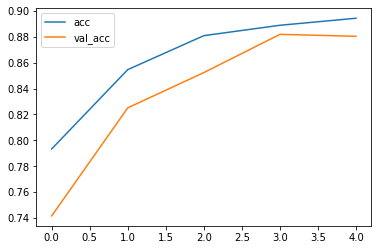

<Figure size 432x288 with 0 Axes>

In [91]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

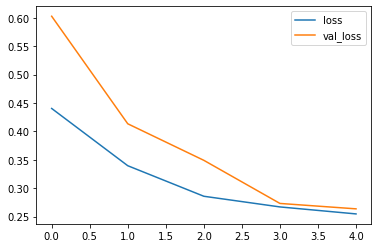

<Figure size 432x288 with 0 Axes>

In [92]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

## CNN + Bi-LSTM

In [102]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=200))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64,dropout=0.5,recurrent_dropout=0.5)))
model.add(Dense(24,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 200, 100)          9453100   
                                                                 
 conv1d_2 (Conv1D)           (None, 200, 32)           9632      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 24)                3096      
                                                                 
 dense_16 (Dense)            (None, 1)               

In [103]:
# compile network
checkpoint = ModelCheckpoint("my_h9_model_text1.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]


In [104]:
# fit network
history = model.fit(X_re,Y_re,validation_split=0.2,epochs=5,batch_size=32,callbacks=callbacks)

Epoch 1/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.8876
Epoch 1: saving model to my_h9_model_text.h5
2895/2895 [==============================] - 556s 190ms/step - loss: 0.2747 - accuracy: 0.8876 - val_loss: 0.2455 - val_accuracy: 0.8934
Epoch 2/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.9099
Epoch 2: saving model to my_h9_model_text.h5
2895/2895 [==============================] - 536s 185ms/step - loss: 0.2230 - accuracy: 0.9099 - val_loss: 0.2423 - val_accuracy: 0.9023
Epoch 3/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.9182
Epoch 3: saving model to my_h9_model_text.h5
2895/2895 [==============================] - 539s 186ms/step - loss: 0.2011 - accuracy: 0.9182 - val_loss: 0.2471 - val_accuracy: 0.9015
Epoch 4/5
2895/2895 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9264
Epoch 4: saving model to my_h9_model_text.h5
2895/2895 [==========

In [105]:
#Saving the Model
model_json = model.to_json()
with open("model_h9_text1.json","w") as json_file:
    json_file.write(model_json)

In [106]:
#TO open the model without training

# to open 
from keras.models import model_from_json
json_file = open('model_h9_text1.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("my_h9_model_text1.h5")


In [107]:
predict_x=loaded_model.predict(test_data) 


#Y_test
classes_x=np.rint(predict_x)

Y_pred = classes_x.flatten()


905/905 [==============================] - 16s 13ms/step


In [108]:
print("Accuracy-:",accuracy_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n",classification_report(Y_test,Y_pred))

Accuracy-: 0.8994990499222664
Confusion Matrix:
 [[21494   843]
 [ 2066  4542]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94     22337
           1       0.84      0.69      0.76      6608

    accuracy                           0.90     28945
   macro avg       0.88      0.82      0.85     28945
weighted avg       0.90      0.90      0.90     28945



### Naive Bayes

In [47]:
from sklearn.naive_bayes import MultinomialNB

In [48]:
nb = MultinomialNB()
nb.fit(X_re,Y_re.ravel())

MultinomialNB()

In [50]:
predicted = nb.predict(test_data)

In [51]:
print("Accuracy-:",accuracy_score(Y_test,predicted))
print("Confusion Matrix:\n",confusion_matrix(Y_test, predicted))
print("Classification Report:\n",classification_report(Y_test,predicted))

Accuracy-: 0.6289514596648816
Confusion Matrix:
 [[15131  7206]
 [ 3534  3074]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74     22337
           1       0.30      0.47      0.36      6608

    accuracy                           0.63     28945
   macro avg       0.55      0.57      0.55     28945
weighted avg       0.69      0.63      0.65     28945



## Support Vector Classifier

In [52]:
from sklearn.svm import LinearSVC
LSVC = LinearSVC()
LSVC.fit(X_re,Y_re.ravel())

C:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [53]:
LSVC_pre = LSVC.predict(test_data)

In [54]:
print("Accuracy-:",accuracy_score(Y_test,LSVC_pre))
print("Confusion Matrix:\n",confusion_matrix(Y_test, LSVC_pre))
print("Classification Report:\n",classification_report(Y_test,LSVC_pre))

Accuracy-: 0.4479530143375367
Confusion Matrix:
 [[ 8438 13899]
 [ 2080  4528]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.38      0.51     22337
           1       0.25      0.69      0.36      6608

    accuracy                           0.45     28945
   macro avg       0.52      0.53      0.44     28945
weighted avg       0.68      0.45      0.48     28945

